# Learning a model

In [114]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# https://github.com/millejoh/emacs-ipython-notebook/issues/41
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


In [115]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

In [116]:
df=pd.read_csv("data/religion.csv")
df.head()

    promney  rfrac
0  0.047790   0.00
1  0.051199   0.01
2  0.054799   0.02
3  0.058596   0.03
4  0.062597   0.04

In [117]:
x=df.rfrac.values
f=df.promney.values

In [118]:
np.random.seed(99)
indexes=np.sort(np.random.choice(x.shape[0], size=30, replace=False))

In [119]:
samplex = x[indexes]
samplef = f[indexes]

In [120]:
sigma=0.06
mask=(x > 0.65) & (x < 0.8)
sigmalist=sigma+mask*0.03

In [121]:
np.random.seed(99)
y = f + st.norm.rvs(scale=sigmalist, size=200)
#the next three lines just ensure that y remains a probability
yadd = (y < 0.0) *(0.01-y)
ysub = (y > 1.0)*(y - 1.0)
y = y + yadd -ysub

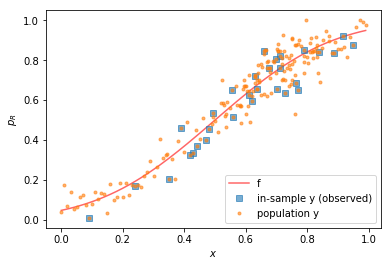

In [122]:
plt.plot(x,f, 'r-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.6, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.6, label="population y");
plt.xlabel('$x$');
plt.ylabel('$p_R$')
plt.legend(loc=4);

In [123]:
df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

In [124]:
from sklearn.model_selection import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
np.random.seed(111)
itrain,itest = train_test_split(range(30),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

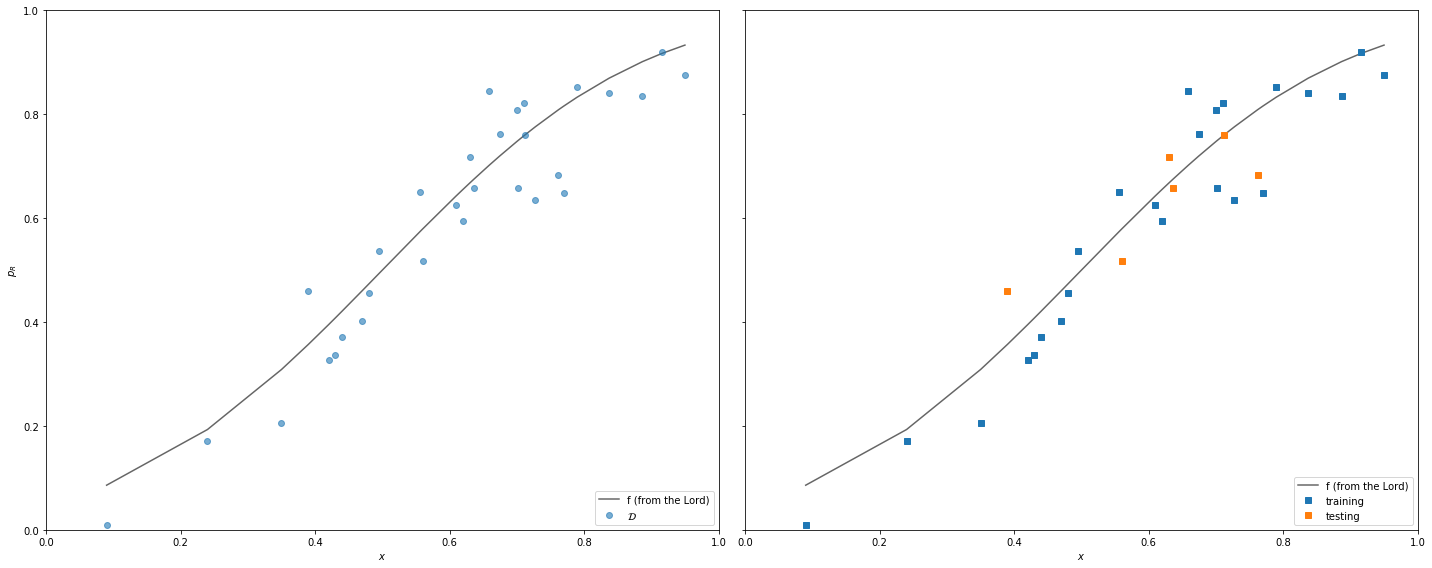

In [125]:
axes=make_plot()
axes[0].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[0].plot(df.x,df.y, 'o',alpha=0.6, label="$\cal{D}$");
axes[1].plot(df.x,df.f, 'k-', alpha=0.6, label="f (from the Lord)");
axes[1].plot(xtrain, ytrain, 's', label="training")
axes[1].plot(xtest, ytest, 's', label="testing")
axes[0].legend(loc="lower right")
axes[1].legend(loc="lower right")

In [126]:
def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

In [127]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees=range(21)
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

traintestlists=make_features(xtrain, xtest, degrees)

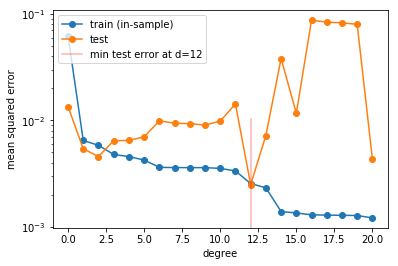

In [128]:
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    prediction_on_training = est.predict(Xtrain)
    prediction_on_test = est.predict(Xtest)
    #calculate mean squared error
    error_train[d] = mean_squared_error(ytrain, prediction_on_training)
    error_test[d] = mean_squared_error(ytest, prediction_on_test)

plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(np.argmin(error_test), 0,0.5, color='r', label="min test error at d=%d"%np.argmin(error_test), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

![m:caption](images/complexity-error-plot.png)

## Validation

There is a problem with the process above which is not apparent at first look. What we have done in picking a given $d$ as the best hypothesis is that we have used the test set as a training set. How?

Our process used the training set to fit for the **parameters**(values of the coefficients) of the polynomial of given degree $d$ based on minimizing the traing set error (empirical risk minimization). We then calculated the error on the test set at that $d$. If we go further and choose the best $d$ based on minimizing the test set error, we have then "fit for" $d$ on the test set. We will thus call $d$ a **hyperparameter** of the model.

In this case, the test-set error will underestimate the true out-of-sample error (for a proof of this see Abu-Mostafa, Yaser S., Malik Magdon-Ismail, and Hsuan-Tien Lin. Learning from data. AMLBook, 2012.). Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we must introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](images/train-validate-test.png)

We have split the old training set into a training set and a validation set, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E}_{test}$ ($R_{test}$).

![m:caption](images/train-validate-test-cont.png)

The validation process is illustrated in these two figures. We first loop ober all the hypothesis sets that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](images/train-validate-test3.png)

Having picked the hyperparameter $d_*$, we retrain using the hypothesis set $\cal{H}_{*}$ on the entire old training-set to find the parameters of the polynomial of order $d_*$ and the corresponding best fit hypothesis $g_*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E}_{test}$.

Thus the **validation** set if the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

YOUR TURN HERE:
>fit on the whole training set below after finding the best model. Store in variable `err` the mean squared error.

In [129]:
#we split the training set down further
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

#we now train on the smaller training set
for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid)
#need to remake polynomial features on the whole training set
ttlist=make_features(xtrain, xtest, degrees)
features_at_mindeg = ttlist[mindeg]['train']
test_features_at_mindeg = ttlist[mindeg]['test']
#fit on whole training set now. Put MSE in variable err.
#your code here
est = LinearRegression()
est.fit(features_at_mindeg, ytrain)
pred = est.predict(test_features_at_mindeg)
err = mean_squared_error(ytest, pred)

6


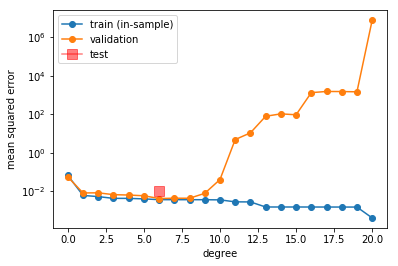

In [130]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print(mindeg)

Lets do this again, choosing a new random split between training and validation data: 

In [131]:
intrain,invalid = train_test_split(itrain,train_size=18, test_size=6)
xntrain= df.x[intrain].values
fntrain = df.f[intrain].values
yntrain = df.y[intrain].values
xnvalid= df.x[invalid].values
fnvalid = df.f[invalid].values
ynvalid = df.y[invalid].values

degrees=range(21)
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
trainvalidlists=make_features(xntrain, xnvalid, degrees)

for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from x
    Xntrain = trainvalidlists[d]['train']
    Xnvalid = trainvalidlists[d]['test']
    #fit a model linear in polynomial coefficients on the training set
    est = LinearRegression()
    est.fit(Xntrain, yntrain)
    #calculate mean squared error
    error_train[d] = mean_squared_error(yntrain, est.predict(Xntrain))
    error_valid[d] = mean_squared_error(ynvalid, est.predict(Xnvalid))

mindeg = np.argmin(error_valid)
ttlist=make_features(xtrain, xtest, degrees)
features_at_mindeg = ttlist[mindeg]['train']
test_features_at_mindeg = ttlist[mindeg]['test']
clf = LinearRegression()
clf.fit(features_at_mindeg, ytrain) # fit
pred = clf.predict(test_features_at_mindeg)
err = mean_squared_error(ytest, pred)

2


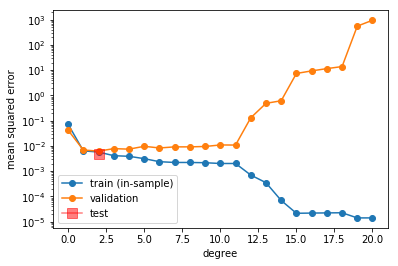

In [132]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='lower left')
plt.yscale("log")
print(mindeg)

This time the validation error minimizing polynomial degree might change! What happened?

## Cross Validation

### The problem

1. Since we are dealing with small data sizes here, you should worry that a given split exposes us to the peciliarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.
2. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: in other words, just like in the hair example, it gives us a distribution.
3. Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible. But the smaller the validation set is, the more data we have to train ourmodel on. Thus we can fit a better, more expressive model. We want to balance these two desires, and additionally, not be exposed to any peculiarities that might randomly arise in any single train-validate split of the old training set.

### The Idea

To deal with this we engage in a process called **cross-validation**, which is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denotet as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

### The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

It can also shown that **cross-validation error is an unbiased estimate of the out of sample-error**.

Let us now do 4-fold cross-validation on our Romney votes data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the ramining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

In [133]:
from sklearn.model_selection import KFold
n_folds=4
degrees=range(21)
results=[]
for d in degrees:
    hypothesisresults=[]
    kf=KFold(n_folds)
    for train, test in kf.split(range(24)): # split data into train/test groups, 4 times
        tvlist=make_features(xtrain[train], xtrain[test], degrees)
        clf = LinearRegression()
        clf.fit(tvlist[d]['train'], ytrain[train]) # fit
        hypothesisresults.append(mean_squared_error(ytrain[test], clf.predict(tvlist[d]['test']))) # evaluate score function on held-out data
    results.append((np.mean(hypothesisresults), np.min(hypothesisresults), np.max(hypothesisresults), np.std(hypothesisresults))) # average

1


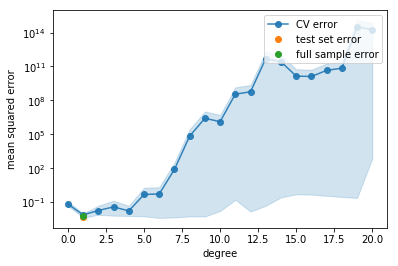

In [134]:
mindeg = np.argmin([r[0] for r in results])
print(mindeg)
ttlist=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
clf = LinearRegression()
clf.fit(ttlist[mindeg]['train'], ytrain) # fit
pred = clf.predict(ttlist[mindeg]['test'])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, clf.predict(ttlist[mindeg]['train']))
errout=0.8*errtr+0.2*err
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
#plt.errorbar(degrees, [r[0] for r in results], yerr=[r[1] for r in results], marker='o', label='CV error', alpha=0.5)
plt.plot(degrees, [r[0] for r in results], marker='o', label='CV error', alpha=0.9)
plt.fill_between(degrees, [r[1] for r in results], [r[2] for r in results], color=colors[0], alpha=0.2)


plt.plot([mindeg], [err], 'o',  label='test set error')
plt.plot([mindeg], [errout], 'o',  label='full sample error')


plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

## Regularization

Upto now we have focussed on finding the polynomial with the right degree of complecity $d=*$ given the data that we have.

Let us now ask a different question: if we are going to fit the data with an expressive model such as 20th order polynomials, how can we **regularize** or smooth or restrict the choices of the kinds of 20th order polynomials that we allow in our fits. In other words, we are again trying to bring down the complexity of the hypothesis space, but by a different tack: a tack which prefers smooth polynomials over wiggly ones.

That is, if we want to fit with a 20th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions in $\cal{H}_{20}$ that we allow.

In a sense we have already done this, havent we? When we compared $\cal{H}_1$ over $\cal{H}_{20}$, we imposed a **hard constraint** by setting all polynomial co-efficients for terms higher than $x$ to 0. In other words you can think of a line as a 20th degree polynomial with many 0 coefficients. Why not have the math machinery do this for you than do it by hand, and use the data to figure out how to make the cut. 

We do this by a **soft constraint** by setting:

$$\sum_{i=0}^j a_i^2 < C.$$

This setting is called the Ridge.

This ensures that the coefficients dont get too high, which makes sure we dont get wildly behaving pilynomials with high coefficients. If we set 

$$\sum_{i=0}^j | a_i | < C,$$

it can be shown that some coefficients will be set to exactly 0. This is called the Lasso.

It turns out that we can do this by adding a term to the empirical risk that we minimize on the training data for $\cal{H}_j$ (seeing why is beyond the scope here but google on lagrange multipliers and the dual problem):

$$\cal{R}(h_j) =  \sum_{y_i \in \cal{D}} (y_i - h_j(x_i))^2 +\alpha \sum_{i=0}^j a_i^2.$$

This new risk takes the empirical risk and adds a "penalty term" to it to minimize overfitting. The term is proportional to the sum of the squares of the coefficients and is positive, so it will keep their values down

Notice that we are adding a term to the **training error**, once $\alpha$ is defined. The entire structure is similar to what we did to find the optimal $d=*$, with $\alpha$ being the analog of $d$. And thus we can use the same validation and cross-validation technology that we developed to estimate $d$.

This technique is called **regularization** or **shrinkage** as it takes the coefficients $a_i$ towards smaller sizes. As you have seen earlier, for polynomials this corresponds to choosing smooth functions over wiggly functions. When $\alpha=0$ we have the regular polynomial regression problem, and if we are using 20th order polynomials we will wildly overfit. We are in the high variance zone. The problem with a non-zero $\alpha$ is called **ridge regression**. As $\alpha$ increases, the importance of the penalty term increases at the expense of the ERM term, and we are pushed to increase the smoothness of the polynomials. When $\alpha$ becomes very large the penalty term dominates and we get into the high bias zone. Thus $\alpha$ acts as a complexity parameter just like $d$ did, with high complexity being $\alpha \to 0$.

Even though we are not doing any proofs, let us illustrate the concept of regularization using a line fit to a sine wave. We fit a straight line to 3 points, choosing 100 such sets of 3 points from the data set.

(100, 3)


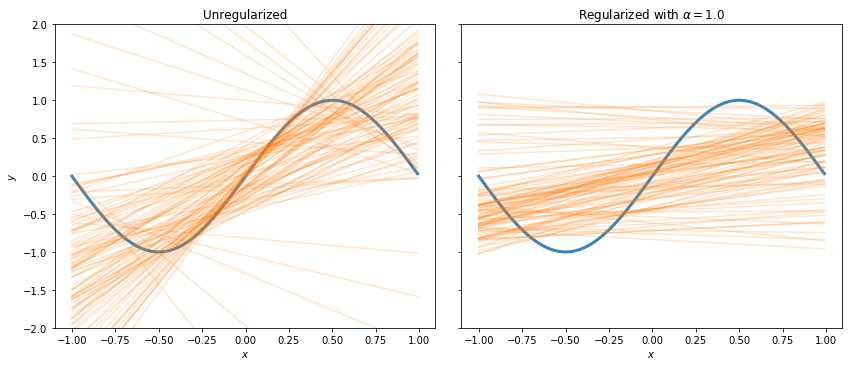

In [135]:
xs=np.arange(-1.,1.,0.01)
ff = lambda x: np.sin(np.pi*x)
ffxs=ff(xs)
axes=make_simple_plot()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
c0=colors[0]
c1=colors[1]
axes[0].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
axes[1].plot(xs, ff(xs), alpha=0.9, lw=3, color=c0)
from sklearn.linear_model import Ridge
D=np.empty((100,3), dtype="int")
print(D.shape)
for i in range(100):
    D[i,:] = np.random.choice(200, replace=False, size=3)
for i in range(100):
    choices = D[i,:]
    #regular fit
    p1=np.polyfit(xs[choices], ffxs[choices],1)
    #ridge fit
    est = Ridge(alpha=1.0)
    est.fit(xs[choices].reshape(-1,1), ffxs[choices])
    axes[0].plot(xs, np.polyval(p1, xs), color=c1, alpha=0.2)
    axes[1].plot(xs, est.predict(xs.reshape(-1,1)), color=c1, alpha=0.2)
axes[0].set_title("Unregularized");
axes[1].set_title("Regularized with $\\alpha=1.0$");

In the left panel we plot unregularized straight line fits. The plot is hairy, since choosing 3 points from 200 between -1 and 1 dosent constrain the lines much at all. On the right panel, we plot the output of **Ridge** regression with $\alpha=1$. This corresponds to adding a term to the empirical risk of $\alpha\, (a_0^2 + a_1^2)$ where $a_0$ and $a_1$ are the intercept and slope of the line respectively. Notice that the lines are much more constrained  in this second plot. The penalty term has regularized the values of the intercept and slope, and forced the intercept to be closer to 0 and the lines to be flatter.

### Regularization of the Romney model with Cross-Validation

In [136]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

Lets now go back to the Romney voting model and see what regularization does to the fits in that model. The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{20}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 20th order polynomials indexed by $\alpha_*$ (there is an error on the diagram, the 13 there should actually be a 20).

![m:caption](images/complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

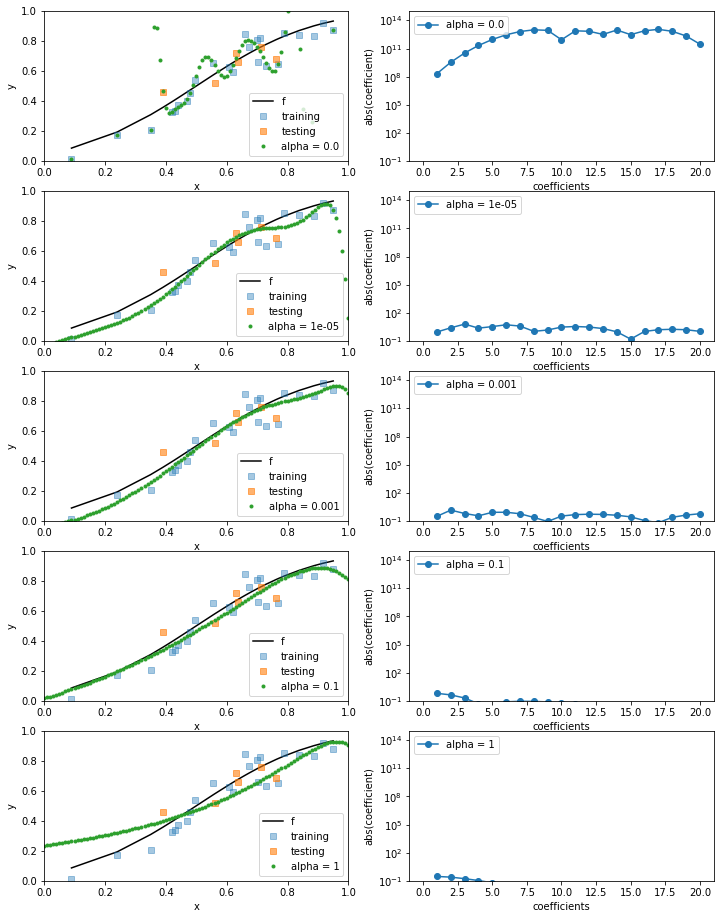

In [137]:
fig, rows = plt.subplots(5, 2, figsize=(12, 16))
d=20
alphas = [0.0, 1e-5, 1e-3, 1e-1, 1]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as we increase $\alpha$ from 0 to 1, we start out overfitting, then doing well, and then, our fits, develop a mind of their own irrespective of data, as the penalty term dominates the risk.

Lets use cross-validation to figure what this critical $\alpha_*$ is. To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(clf, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doint it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $\alpha$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $\alpha$'s, and picks the best choice model.

In [138]:
from sklearn.metrics import make_scorer
#, 1e-6, 1e-5, 1e-3, 1.0
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(X, y)
    return gs

In [139]:
fitmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)

In [140]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.cv_results_

/Users/kazuki/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/kazuki/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/kazuki/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/kazuki/miniconda3/li

(Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 {'alpha': 0.01},
 -0.0069857086832592575,
 {'mean_fit_time': array([ 0.00441325,  0.0009746 ,  0.00098985,  0.00098842,  0.00081456,
          0.00102496,  0.00078225,  0.00083464,  0.00083214,  0.00086886]),
  'mean_score_time': array([ 0.0003795 ,  0.00031763,  0.0003292 ,  0.00032318,  0.00027794,
          0.00029904,  0.0002718 ,  0.00028682,  0.00029624,  0.00030828]),
  'mean_test_score': array([-0.09739534, -0.02057523, -0.00915934, -0.00981845, -0.01238245,
         -0.01531965, -0.0140078 , -0.00698571, -0.0075996 , -0.01833041]),
  'mean_train_score': array([-0.00332682, -0.00344042, -0.00360427, -0.00373768, -0.003792  ,
         -0.00396163, -0.00407287, -0.00456281, -0.00613537, -0.01445638]),
  'param_alpha': masked_array(data = [1e-08 1e-06 1e-05 5e-05 0.0001 0.0005 0.001 0.01 0.1 1.0],
               mask = [False False False False Fals

Our best model occurs for $\alpha=0.01$. We also output the mean cross-validation error at different $\alpha$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

We refit the estimator on old training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.

YOUR TURN NOW:
>assign to variable clf the classifier obtained by fitting the entire training set using the best $\alpha$ found above.

In [141]:
#Store in clf a new classifier fit on the entire training set with the best alpha
#your code here
alphawechoose = fitmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [142]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

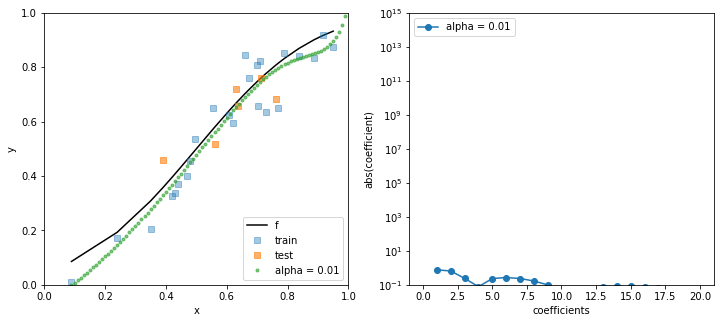

In [143]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)

As we can see, the best fit model is now chosen from the entire set of 20th order polynomials, and a non-zero hyperparameter $\alpha$ that we fit for ensures that only smooth models amonst these polynomials are chosen, by setting most of the polynomial coefficients to something close to 0 (Lasson sets them exactly to 0).

### What is minimized where?

Regularization adds a term to the error or risk, which is then, for fixed $\alpha$, minimized on the training set.
The validation error is then calculated on the validation set and reported alongside the value of $\alpha$ used. If we cross-validate, then the validation error is an average over multiple folds.

On the other hand, when we validate for $d$, we use the validation error as an estimate of the out-of-sample error and use this estimate to directly pick the best model (best $d$).

One can think of **regularization as an estimation of the overfit term** while **validation directly estimates $R_{out}$**.

## A multiple regression problem: Boston Dataset

In [144]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR'])


In [145]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

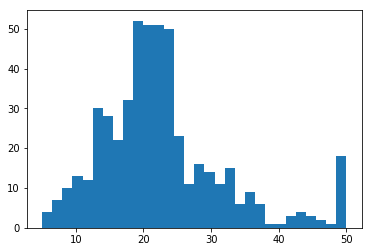

In [146]:
plt.hist(boston.target, bins=30);

In [147]:
boston.data

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00, ...,
          1.53000000e+01,   3.96900000e+02,   4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.96900000e+02,   9.14000000e+00],
       [  2.72900000e-02,   0.00000000e+00,   7.07000000e+00, ...,
          1.78000000e+01,   3.92830000e+02,   4.03000000e+00],
       ..., 
       [  6.07600000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   5.64000000e+00],
       [  1.09590000e-01,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.93450000e+02,   6.48000000e+00],
       [  4.74100000e-02,   0.00000000e+00,   1.19300000e+01, ...,
          2.10000000e+01,   3.96900000e+02,   7.88000000e+00]])

In [148]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='<U7')

In [149]:
boston.data[:,-1]

array([  4.98,   9.14,   4.03,   2.94,   5.33,   5.21,  12.43,  19.15,
        29.93,  17.1 ,  20.45,  13.27,  15.71,   8.26,  10.26,   8.47,
         6.58,  14.67,  11.69,  11.28,  21.02,  13.83,  18.72,  19.88,
        16.3 ,  16.51,  14.81,  17.28,  12.8 ,  11.98,  22.6 ,  13.04,
        27.71,  18.35,  20.34,   9.68,  11.41,   8.77,  10.13,   4.32,
         1.98,   4.84,   5.81,   7.44,   9.55,  10.21,  14.15,  18.8 ,
        30.81,  16.2 ,  13.45,   9.43,   5.28,   8.43,  14.8 ,   4.81,
         5.77,   3.95,   6.86,   9.22,  13.15,  14.44,   6.73,   9.5 ,
         8.05,   4.67,  10.24,   8.1 ,  13.09,   8.79,   6.72,   9.88,
         5.52,   7.54,   6.78,   8.94,  11.97,  10.27,  12.34,   9.1 ,
         5.29,   7.22,   6.72,   7.51,   9.62,   6.53,  12.86,   8.44,
         5.5 ,   5.7 ,   8.81,   8.2 ,   8.16,   6.21,  10.59,   6.65,
        11.34,   4.21,   3.57,   6.19,   9.42,   7.67,  10.63,  13.44,
        12.33,  16.47,  18.66,  14.09,  12.27,  15.55,  13.  ,  10.16,
      

In [150]:
dfboston=pd.DataFrame({k:boston.data[:,i] for i,k in enumerate(boston.feature_names)})
dfboston.head()

    AGE       B  CHAS     CRIM     DIS  INDUS  LSTAT    NOX  PTRATIO  RAD     RM    TAX    ZN
0  65.2  396.90   0.0  0.00632  4.0900   2.31   4.98  0.538     15.3  1.0  6.575  296.0  18.0
1  78.9  396.90   0.0  0.02731  4.9671   7.07   9.14  0.469     17.8  2.0  6.421  242.0   0.0
2  61.1  392.83   0.0  0.02729  4.9671   7.07   4.03  0.469     17.8  2.0  7.185  242.0   0.0
3  45.8  394.63   0.0  0.03237  6.0622   2.18   2.94  0.458     18.7  3.0  6.998  222.0   0.0
4  54.2  396.90   0.0  0.06905  6.0622   2.18   5.33  0.458     18.7  3.0  7.147  222.0   0.0

In [151]:
itrain, itest = train_test_split(range(len(boston.target)))

In [152]:
dfboston.iloc[itrain]

       AGE       B  CHAS      CRIM     DIS  INDUS  LSTAT     NOX  PTRATIO   RAD     RM    TAX    ZN
283   24.8  395.52   1.0   0.01501  5.8850   1.21   3.16  0.4010     13.6   1.0  7.923  198.0  90.0
236   76.5  388.45   1.0   0.52058  4.1480   6.20   9.54  0.5070     17.4   8.0  6.631  307.0   0.0
47    85.5  392.74   0.0   0.22927  5.6894   6.91  18.80  0.4480     17.9   3.0  6.030  233.0   0.0
102   85.4   70.80   0.0   0.22876  2.7147   8.56  10.63  0.5200     20.9   5.0  6.405  384.0   0.0
426   59.7   24.65   0.0  12.24720  1.9976  18.10  15.69  0.5840     20.2  24.0  5.837  666.0   0.0
442  100.0  395.69   0.0   5.66637  2.0048  18.10  16.59  0.7400     20.2  24.0  6.219  666.0   0.0
212   53.8  390.94   1.0   0.21719  3.6526  10.59  16.03  0.4890     18.6   4.0  5.807  277.0   0.0
350   44.4  396.90   0.0   0.06211  8.7921   1.25   5.98  0.4290     19.7   1.0  6.490  335.0  40.0
502   76.7  396.90   0.0   0.04527  2.2875  11.93   9.08  0.5730     21.0   1.0  6.120  273.0   0.0


In [153]:
boston.target[itrain]

array([ 50. ,  25.1,  16.6,  18.6,  10.2,  18.4,  22.4,  22.9,  20.6,
        22.6,  23.1,  22.2,  21.8,  24.1,  27.9,  24.8,  23.8,  43.1,
        23.9,  20.5,  23.7,  35.4,  22. ,  20.8,  16.1,  17.2,  13.2,
        50. ,  34.7,  20.6,  23.1,  22.8,  29.1,  30.1,  18.7,  15.6,
         9.7,   8.3,  24.4,  17.8,  10.4,  30.5,  25. ,  26.7,  23.7,
        32. ,  17.2,  33.3,  28.4,  15.1,  19.3,  14.6,  17.4,   7.2,
        33.1,   7.2,  21.2,   5. ,  22.4,  27.5,  20.1,  50. ,   8.3,
        27. ,  21.4,  28.6,  18.9,  19.7,  23.3,  18.2,  16.5,  15.6,
        22. ,  16.8,  14.3,  36.4,  20.4,  24. ,   5.6,  26.4,  17.6,
        19.3,  24.4,   8.1,  34.9,  24.8,  30.7,  22.6,  20.1,  37.2,
        37. ,  33.1,  22.5,  24.6,  41.3,  13.3,  21.7,  34.9,  19.5,
        15.6,  17.3,  22.2,  15.3,  31.5,  25. ,  17.8,  16.2,  19.3,
        13.1,  14.9,  24.8,  28.7,  13.8,  14.1,  17.8,  13.1,  16.4,
        18.6,  12. ,  17.5,  23.8,  19.2,  13.6,  10.4,  16.7,  23.1,
        20.6,  19.3,

In [154]:
lr = LinearRegression()

In [155]:
lr.fit(dfboston[['LSTAT','AGE']].iloc[itrain], boston.target[itrain])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [156]:
mean_squared_error(boston.target[itest], lr.predict(dfboston[['LSTAT','AGE']].iloc[itest]))

49.419870265519457

$R^2$ is a metric often used in regression, and is defined as:

$$R^2  = 1  -  \frac{MSE}{normed\, distance\, of\, data\, from\, mean}$$

In [157]:
lr.score(dfboston[['LSTAT','AGE']].iloc[itest], boston.target[itest])

0.57364859096854859

In [158]:
dfboston2=dfboston.copy()
dfboston2['LSTAT:AGE']=dfboston2['LSTAT']*dfboston2['AGE']
lr2 = LinearRegression()

In [159]:
lr2.fit(dfboston2[['LSTAT','AGE','LSTAT:AGE']].iloc[itrain], boston.target[itrain])
mean_squared_error(boston.target[itest], lr2.predict(dfboston2[['LSTAT','AGE', 'LSTAT:AGE']].iloc[itest]))

49.626340952243446

In [163]:
# interaction as in R
lr2.score(dfboston2[['LSTAT','AGE', 'LSTAT:AGE']].iloc[itest], boston.target[itest])

0.57186734250036131

YOUR TURN HERE
>Just like `cv_optimize_ridge`, write a function for the Lasso `def cv_optimize_lasso(X, y, n_folds=5):` which uses `L1` regularization in linear regression. It can use the `cv_optimize` function from above

In [166]:
#your code here
from sklearn.linear_model import Lasso
def cv_optimize_lasso(X, y, n_folds=4):
    clf = Lasso()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(X, y)
    return gs

In [167]:
xtrain = dfboston.iloc[itrain]
xtest = dfboston.iloc[itest]
ytrain = boston.target[itrain]
ytest = boston.target[itest]
clf_boston = cv_optimize_lasso(xtrain, ytrain)

In [168]:
clf_boston = clf_boston.best_estimator_
clf_boston.fit(xtrain, ytrain)
predicted = clf_boston.predict(xtest)

In [169]:
mean_squared_error(ytest, predicted)

28.280677395769235

In [170]:
clf_boston.score(dfboston.iloc[itest], boston.target[itest])

0.75601905486055621

Text(0,0.5,'Predicted price ($1000s)')

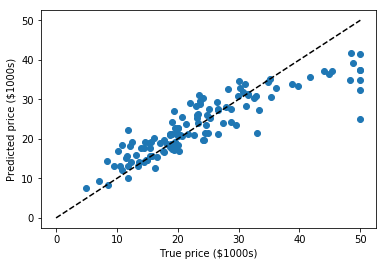

In [171]:
plt.scatter(ytest, predicted)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)')

In [172]:
def nonzero_lasso(clf, lcols):
    featuremask=(clf.coef_ !=0.0)
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_, abscoef=np.abs(clf.coef_)))[featuremask].sort_values('abscoef', ascending=False)

In [173]:
list(dfboston.columns)

['AGE',
 'B',
 'CHAS',
 'CRIM',
 'DIS',
 'INDUS',
 'LSTAT',
 'NOX',
 'PTRATIO',
 'RAD',
 'RM',
 'TAX',
 'ZN']

In [174]:
clf_boston.coef_

array([ -1.13125770e-02,   9.45637857e-03,   1.78811843e+00,
        -1.21217157e-01,  -1.72343032e+00,  -1.59301435e-03,
        -4.62745905e-01,  -1.88413216e+01,  -9.80081715e-01,
         2.98006652e-01,   2.97391003e+00,  -1.16368593e-02,
         6.02983856e-02])

In [175]:
lasso_importances=nonzero_lasso(clf_boston, list(dfboston.columns))
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

           abscoef       coef
feature                      
NOX      18.841322 -18.841322
RM        2.973910   2.973910
CHAS      1.788118   1.788118
DIS       1.723430  -1.723430
PTRATIO   0.980082  -0.980082
LSTAT     0.462746  -0.462746
RAD       0.298007   0.298007
CRIM      0.121217  -0.121217
ZN        0.060298   0.060298
TAX       0.011637  -0.011637

**Exercise for home**: Use polynomial regression of order 2 and order 3 including interaction terms and see if you can improve the $R^2$.